In [6]:
import sys
# need to add cocpit dir to path - can't relative import with sister directory
sys.path.insert(0, "..") 

import cocpit
import cocpit.config as config
import cocpit.plot as plot

import itertools
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")


import torch
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
from matplotlib.colors import Normalize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
plt_params = {
    "axes.labelsize": "xx-large",
    "axes.titlesize": "xx-large",
    "xtick.labelsize": "xx-large",
    "ytick.labelsize": "xx-large",
    "legend.title_fontsize": 12,
}
plt.rcParams["font.family"] = "serif"
plt.rcParams.update(plt_params)

In [5]:
 torch.cuda.empty_cache()

### plot confusion matrix on all validation dataloaders from cross fold validation

In [ ]:
"""
iterate through each fold and append predictions and actual labels
changing saved model and validation data each time
"""

all_preds = []
all_labels = []
for fold in range(5):
    val_data = torch.load(
        "/data/data/saved_val_loaders/no_mask/v1.3.0/val_loader20_bs64_k"
        + str(fold)
        + "_1models_vgg16_no_blank.pt"
    )
    saved_model_name = (
        "/data/data/saved_models/no_mask/v1.3.0/e20_bs64_k"
        + str(fold)
        + "_1models_no_blank_vgg16"
    )
    

    model = torch.load(saved_model_name).cuda()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    result = saved_model_name.find("bs")
    batch_size = int(saved_model_name[result + 2 : result + 4])

    # get predictions from val loader
    preds, labels = cocpit.data_loaders.get_val_loader_predictions(
        model, val_data, device, batch_size
    )
    all_preds.append(preds)
    all_labels.append(labels)

In [ ]:
all_preds = list(itertools.chain(*all_preds))
all_labels = list(itertools.chain(*all_labels))

In [ ]:
# plot/save conf matrix
save_name = "/data/data/plots/conf_matrix_allfolds.pdf"

cocpit.plot_metrics.confusion_matrix(
    all_preds, all_labels, norm=False, save_name=save_name, save_fig=True
)

In [ ]:
# plot/save normalized conf matrix
save_name = "/data/data/plots/norm_conf_matrix_allfolds.pdf"
cocpit.plot_metrics.confusion_matrix(
    all_preds, all_labels, norm=True, save_name=save_name, save_fig=True
)

### plot confusion matrix on one validation dataloader (no folds)

In [8]:
"""
iterate through each fold and append predictions and actual labels
changing saved model and validation data each time
"""

val_data = torch.load(config.VAL_LOADER_SAVENAME)
model = torch.load(config.MODEL_SAVENAME).cuda()
result = config.MODEL_SAVENAME.find("bs")
batch_size = int(config.MODEL_SAVENAME[result + 2 : result + 4])

# get predictions from val loader
all_preds, all_labels = cocpit.data_loaders.get_val_loader_predictions(
    model, val_data, batch_size
)


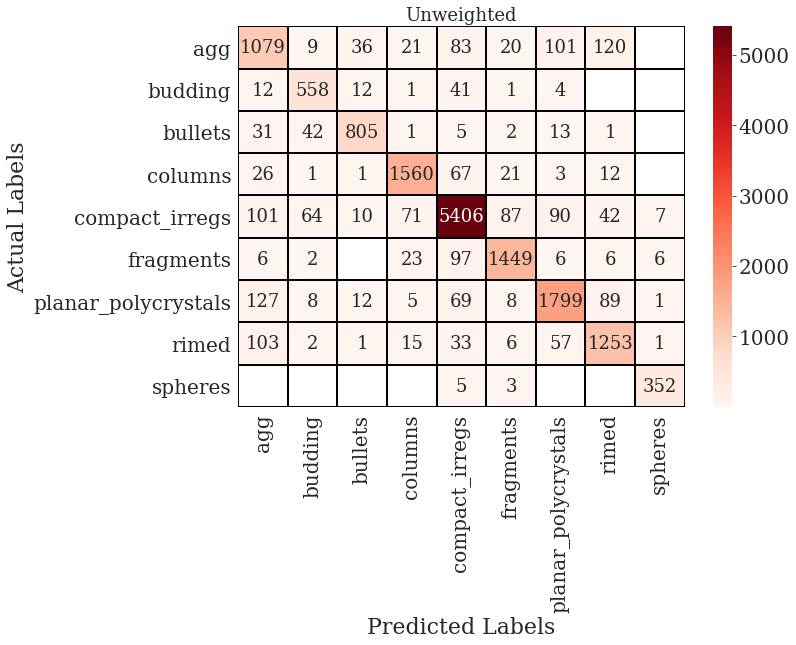

In [9]:
# plot/save conf matrix from one val_loader
# don't normalize (show magnitude of predictions per class)
save_name = "/data/data/plots/conf_matrix_v1.4.0.pdf"

cocpit.plot_metrics.conf_matrix(
    all_preds, all_labels, norm=False, save_name=save_name
)

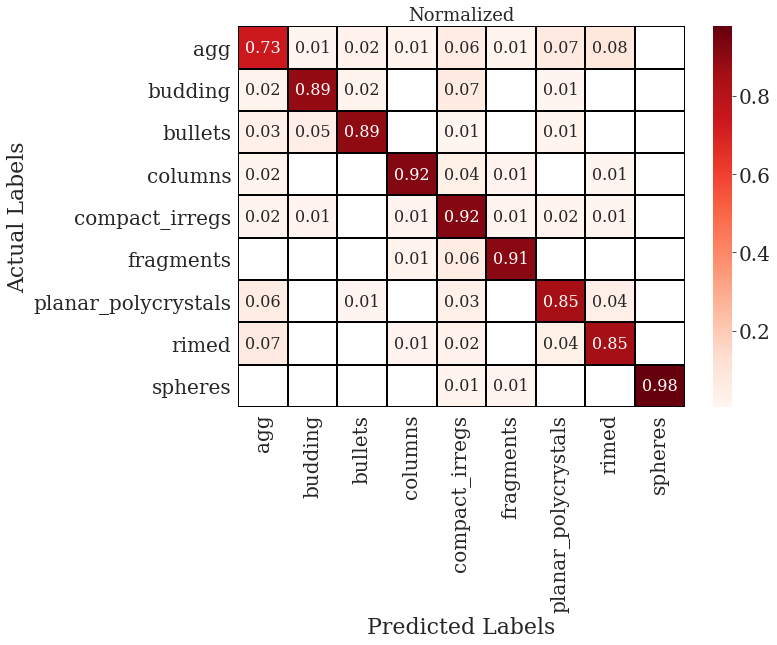

In [10]:
# plot/save conf matrix from one val_loader
# normalize (show relative % of (in)correct predictions)
save_name = "/data/data/plots/norm_conf_matrix_v1.4.0.pdf"

cocpit.plot_metrics.conf_matrix(
    all_preds, all_labels, norm=True, save_name=save_name
)

### classification reports

A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, macro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

In [ ]:
# rename models for plotting
model_names = [
    "efficient",
    "resnet18",
    "resnet34",
    "resnet152",
    "alexnet",
    "vgg16",
    "vgg19",
    "densenet169",
    "densenet201",
]
new_names = [
    "Efficient-b0",
    "ResNet-18",
    "ResNet-34",
    "ResNet-152",
    "AlexNet",
    "VGG-16",
    "VGG-19",
    "DenseNet-169",
    "DenseNet-201",
]
convert_names = {model_names[i]: new_names[i] for i in range(len(new_names))}
convert_names

In [ ]:
"""
classification report w.r.t. each model 
includes variability between classes and folds
"""
metric_filename = (
    "/data/data/saved_accuracies/save_val_metrics_e20_bs64_k5_9_no_blank.csv"
)
save_name = "/data/data/plots/model_metrics_noavg.pdf"
cocpit.plot_metrics.model_metric_folds(
    metric_filename, convert_names, save_name, avg=None, save_fig=True
)

In [ ]:
"""
classification report w.r.t. each model 
includes variability only between folds
plots the macro avg across classes
"""
metric_filename = (
    "/data/data/saved_accuracies/save_val_metrics_e20_bs64_k5_9_no_blank.csv"
)
save_name = "/data/data/plots/model_metrics_variation_folds.pdf"
cocpit.plot_metrics.model_metric_folds(
    metric_filename, convert_names, save_name, avg="classes", save_fig=True
)

In [ ]:
"""
classification report w.r.t. each model 
includes variability only between folds
plots the macro avg across classes
"""
metric_filename = (
    "/data/data/saved_accuracies/save_val_metrics_e20_bs64_k5_9_no_blank.csv"
)
save_name = "/data/data/plots/model_metrics_variation_classes.pdf"
cocpit.plot_metrics.model_metric_folds(
    metric_filename, convert_names, save_name, avg="folds", save_fig=True
)

### plot precision, recall, and f1-score w.r.t. each class

In [ ]:
"""
classification report for best overall performing model (vgg16) w.r.t class
"""
save_name = "/data/data/plots/clf_report_classes_vgg16_all_folds.pdf"
clf_report = cocpit.plot_metrics.metrics_report(
    all_labels, all_preds
)
cocpit.plot_metrics.classification_report_classes(
    clf_report, save_name, save_fig=True
)

### plot batch size vs val acc for vgg16

In [ ]:
val_csv = "/data/data/saved_accuracies/save_val_acc_loss_batchsize_comparew16_32_e20_bs32_k0_1models_no_blank.csv"
save_name = "/data/data/plots/batch_size_vs_val_acc.pdf"
plot.batch_size_accuracy_bar(val_csv, save_name, save_fig=True)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
df_val = pd.read_csv(
    val_csv, names=["Model", "Epoch", "Batch Size", "Accuracy", "Loss"]
)

df_val["Accuracy"] = df_val["Accuracy"] * 100
df = df_val.pivot_table(index='Epoch', columns='Batch Size', values='Accuracy')
df.plot(ylim=[94,98], ax=ax1, cmap=cm.get_cmap("icefire"))
df = df_val.pivot_table(index='Epoch', columns='Batch Size', values='Loss')
df.plot(ylim=[0.0,0.5], ax=ax2, cmap=cm.get_cmap("icefire"))


## plot training and validation accuracy and loss

In [ ]:
train_csv = "/data/data/saved_accuracies/save_train_acc_loss_e20_bs64_k5_9models_no_blank.csv"
df_train = pd.read_csv(
    train_csv, names=["Model", "Epoch", "Kfold", "Batch Size", "Accuracy", "Loss"]
)

df_train.replace(convert_names, inplace=True)
df_train.head()

In [ ]:
val_csv = "/data/data/saved_accuracies/save_val_acc_loss_e20_bs64_k5_9models_no_blank.csv"
df_val = pd.read_csv(
    val_csv, names=["Model", "Epoch", "Kfold", "Batch Size", "Accuracy", "Loss"]
)
df_val.replace(convert_names, inplace=True)
df_val.head()

In [ ]:
colors = {
    "Efficient-b0": "#C76114",
    "ResNet-18": "#CAE1FF",
    "ResNet-34": "#3063A5",
    "ResNet-152": "#162252",
    "AlexNet": "#FCDC3B",
    "VGG-16": "#CD9B9B",
    "VGG-19": "#9E0508",
    "DenseNet-169": "#9CBA7F",
    "DenseNet-201": "#006633",
}
num_epochs = int(val_csv[55:57])
kfold = int(val_csv[64:65])
num_models = len(model_names)

In [ ]:
# reshape data
if kfold == 0:
    val_accs = df_val["Accuracy"].values.reshape(num_models, num_epochs)
    val_losses = df_val["Loss"].values.reshape(num_models, num_epochs)
    train_accs = df_train["Accuracy"].values.reshape(num_models, num_epochs)
    train_losses = df_train["Loss"].values.reshape(num_models, num_epochs)
else:
    val_accs = np.average(
        df_val["Accuracy"].values.reshape(num_models, kfold, num_epochs), axis=1
    )
    val_losses = np.average(
        df_val["Loss"].values.reshape(num_models, kfold, num_epochs), axis=1
    )
    train_accs = np.average(
        df_train["Accuracy"].values.reshape(num_models, kfold, num_epochs), axis=1
    )
    train_losses = np.average(
        df_train["Loss"].values.reshape(num_models, kfold, num_epochs), axis=1
    )

In [ ]:
save_name = "/data/data/plots/loss_acc_9models_bs64_e20_9classes_avg5kfold_noblank.pdf"
plot.train_val_acc_loss(
    model_names,
    num_models,
    num_epochs,
    train_accs,
    colors,
    new_names,
    val_accs,
    train_losses,
    val_losses,
    save_name,
    save_fig=True,
)

### plot accuracy/loss curves for balanced vs unbalanced random samplers

In [ ]:
val_csv_unbalanced = "/data/data/saved_accuracies/save_val_acc_loss_e20_bs64_k0_1models_unbalanced_v1.3.0.csv"
num_epochs = int(val_csv_unbalanced[47:49])
df_val_unbalanced = pd.read_csv(
    val_csv_unbalanced, names=["Model", "Epoch", "Kfold", "Batch Size", "Accuracy", "Loss"]
)
train_csv_unbalanced = "/data/data/saved_accuracies/save_train_acc_loss_e20_bs64_k0_1models_unbalanced_v1.3.0.csv"
df_train_unbalanced = pd.read_csv(
    train_csv_unbalanced, names=["Model", "Epoch", "Kfold", "Batch Size", "Accuracy", "Loss"]
)

val_csv = "/data/data/saved_accuracies/save_val_acc_loss_e20_bs64_k0_1models_balanced_v1.3.0.csv"
df_val = pd.read_csv(
    val_csv, names=["Model", "Epoch", "Kfold", "Batch Size", "Accuracy", "Loss"]
)
train_csv = "/data/data/saved_accuracies/save_train_acc_loss_e20_bs64_k0_1models_balanced_v1.3.0.csv"
df_train = pd.read_csv(
    train_csv, names=["Model", "Epoch", "Kfold", "Batch Size", "Accuracy", "Loss"]
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(13,3)
)

for c, item in enumerate([df_val['Accuracy'].values*100,
                          df_val_unbalanced['Accuracy'].values*100]):
    
    color = 'blue' if c == 0 else 'orange'
    label = 'Unweighted' if c == 1 else 'Weighted'

    ax1.plot(
        np.arange(1,len(df_train_unbalanced['Loss'])+1),
        item,
        color=color,
        label=label
    )
    
    
for c, item in enumerate([df_val['Loss'].values,
                          df_val_unbalanced['Loss'].values]):

    color = 'blue' if c == 0 else 'orange'
    label = 'Unweighted' if c == 1 else 'Weighted'
    
    ax2.plot(
        np.arange(1,len(df_train_unbalanced['Loss'])+1),
        item,
        color=color,
        label=label
    )
ax1.set_ylabel("Accuracy [%]")
ax2.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")
ax1.set_xlim(1, num_epochs)
ax2.set_xlim(1, num_epochs)
ax1.set_ylim(85, 100)
ax1.legend(loc="best", prop={"size": 14})
ax2.legend(loc="best", prop={"size": 14})

ax1.yaxis.set_ticks_position("both")
ax1.minorticks_on()

save_name = "/data/data/plots/unweighted_weighted_sampler_loss_acc_curves.png"
plt.tight_layout()
plt.savefig(save_name)

In [ ]:
clf_report = pd.read_csv('/data/data/saved_accuracies/save_val_metrics_e20_bs64_k0_1_unbalanced_v1.3.0.csv', index_col=0).drop(columns=['model', 'fold'])
save_name = "/data/data/plots/unweighted_classification_report.pdf"


cocpit.plot_metrics.classification_report_classes(
    clf_report, save_name=save_name, save_fig=True
)  #should be lower

In [ ]:
clf_report = pd.read_csv('/data/data/saved_accuracies/save_val_metrics_e20_bs64_k0_1_balanced_v1.3.0.csv', index_col=0).drop(columns=['model', 'fold'])
save_name = "/data/data/plots/weighted_classification_report.pdf"


cocpit.classification_metrics.classification_report_classes(
    clf_report, save_name=save_name, save_fig=True
)

### plot time it takes to train different models

In [ ]:
time_csv = "/data/data/saved_timings/model_timing2.csv"
save_name = "/data/data/plots/training_time.pdf"
plot.model_timing(time_csv, convert_names, colors, save_name, save_fig=False)

### plot time it takes to run different samples

In [ ]:
time_csv = "/data/data/saved_timings/model_timing_samples.csv"
save_name = "/data/data/plots/model_timing_samples.pdf"
plot.time_samples(time_csv, save_name, convert_names, save_fig=True)

In [ ]:
time_csv = "/data/data/saved_timings/model_timing_samples.csv"
save_name = "/data/data/plots/model_efficiency_samples.pdf"
plot.efficiency_samples(time_csv, save_name, convert_names, save_fig=True)

## plot cross validation

In [ ]:
val_accs = df_val["Accuracy"].values.reshape(num_models, kfold, num_epochs)
val_accs_avg = np.average(
    df_val["Accuracy"].values.reshape(num_models, kfold, num_epochs), axis=1
)

In [ ]:
val_accs_avg = {new_names[i]: val_accs_avg[i, -1] for i in range(len(model_names))}
val_accs_avg

In [ ]:
val_accs_avg_sort = dict(sorted(val_accs_avg.items(), key=lambda x: x[1]))
val_accs_avg_sort

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharex=True, sharey=True)
fig.tight_layout(pad=3.0)
# fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(2, 1, 1)

for i in range(num_models):
    ax1.plot(
        np.arange(1, (kfold + 1)),
        [i * 100 for i in val_accs[i, :, -1]],
        c=colors[new_names[i]],
        marker="o",
        label=new_names[i],
    )
plt.ylabel("Accuracy [%]")
plt.xlabel("Fold")
plt.ylim(70, 100)
# plt.xlim(1,num_epochs)
# ax1.legend(title='Model type:', loc='best', prop={'size': 12})
# Shrink current axis by 20%
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)
ax1.axes.xaxis.set_ticks(np.arange(1, 6, 1))
ax1.yaxis.set_ticks_position("both")
ax1.minorticks_on()
ax1.tick_params(axis="y", which="minor", direction="out")
# ax1.xaxis.set_tick_params(which='minor', bottom=False)
ax1.title.set_text("Validation Data Accuracies")

ax2 = plt.subplot(2, 1, 2)
plt.bar(
    np.arange(1, num_models + 1),
    [i * 100 for i in val_accs_avg_sort.values()],
    color=sorted_colors.values(),
)
plt.ylabel("Average Accuracy [%]")
plt.xlabel("Model Name")
plt.ylim(85, 100)
# plt.xlim(1,num_epochs)
# Shrink current axis by 20%
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
# Set number of ticks for x-axis
ax2.set_xticks(np.arange(1, 10))
# Set ticks labels for x-axis
ax2.set_xticklabels(sorted_colors.keys(), rotation="vertical")
ax2.yaxis.set_ticks_position("both")